In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [8]:
df = pd.read_csv("train (3).csv")
print("Shape of dataset:", df.shape)
print(df.head())

Shape of dataset: (700, 2)
      x          y
0  24.0  21.549452
1  50.0  47.464463
2  15.0  17.218656
3  38.0  36.586398
4  87.0  87.288984


In [9]:
df

,x,y
0,24.0,21.549452
1,50.0,47.464463
2,15.0,17.218656
3,38.0,36.586398
4,87.0,87.288984
...,...,...
695,58.0,58.595006
696,93.0,94.625094
697,82.0,88.603770
698,66.0,63.648685


In [10]:
# ------------------------------
# 3. 🧼 Preprocessing
# ------------------------------

# Drop missing values (or impute if needed)
df.dropna(inplace=True)

# Detect and drop outliers using IQR method (for numerical columns)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]


In [11]:
# ------------------------------
# 4. 🔀 Features & Target
# ------------------------------

# Assuming last column is target
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Scale the features (important for regularized models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [13]:
X_train

array([[-1.34839704e+00],
       [-2.07864074e-01],
       [ 8.28984079e-01],
       [-8.64534571e-01],
       [-7.26288151e-01],
       [ 1.45109297e+00],
       [ 6.90737658e-01],
       [ 7.25299264e-01],
       [ 1.14003852e+00],
       [-7.26288151e-01],
       [-6.57164940e-01],
       [-3.50560487e-02],
       [ 6.90737658e-01],
       [ 3.40671615e-02],
       [ 8.28984079e-01],
       [ 7.59860869e-01],
       [-6.22603335e-01],
       [-6.96176538e-02],
       [-3.11548889e-01],
       [ 8.98107289e-01],
       [-1.41752025e+00],
       [ 5.87052843e-01],
       [ 1.27828495e+00],
       [ 6.21614448e-01],
       [ 1.65846260e+00],
       [ 1.48565458e+00],
       [-1.41752025e+00],
       [ 6.21614448e-01],
       [-6.91726546e-01],
       [ 1.52021618e+00],
       [-1.38740864e-01],
       [ 9.32668894e-01],
       [ 1.48565458e+00],
       [ 3.10560002e-01],
       [-3.46110495e-01],
       [-1.48664346e+00],
       [ 1.72313582e-01],
       [-7.60849756e-01],
       [-1.3

In [14]:
# CV strategies
cv_methods = {
    "KFold": KFold(n_splits=5, shuffle=True, random_state=42),
    "RepeatedKFold": RepeatedKFold(n_splits=5, n_repeats=3, random_state=42),
    "ShuffleSplit": ShuffleSplit(n_splits=5, test_size=0.2, random_state=42),
    "LeaveOneOut": LeaveOneOut() if len(df) <= 500 else None  # Optional, only if small dataset
}

In [15]:
cv_methods

{'KFold': KFold(n_splits=5, random_state=42, shuffle=True),
 'RepeatedKFold': RepeatedKFold(n_repeats=3, n_splits=5, random_state=42),
 'ShuffleSplit': ShuffleSplit(n_splits=5, random_state=42, test_size=0.2, train_size=None),
 'LeaveOneOut': None}

In [16]:
# Models and params
models = {
    "Ridge": (Ridge(), {"alpha": [0.01, 0.1, 1, 10, 100]}),
    "Lasso": (Lasso(max_iter=10000), {"alpha": [0.001, 0.01, 0.1, 1, 10]}),
    "ElasticNet": (ElasticNet(max_iter=10000), {
        "alpha": [0.001, 0.01, 0.1, 1],
        "l1_ratio": [0.1, 0.5, 0.7, 0.9]
    })
}


In [17]:
models

{'Ridge': (Ridge(), {'alpha': [0.01, 0.1, 1, 10, 100]}),
 'Lasso': (Lasso(max_iter=10000), {'alpha': [0.001, 0.01, 0.1, 1, 10]}),
 'ElasticNet': (ElasticNet(max_iter=10000),
  {'alpha': [0.001, 0.01, 0.1, 1], 'l1_ratio': [0.1, 0.5, 0.7, 0.9]})}

In [18]:
# Store best results
final_results = {}

print("📊 Starting comparison with multiple CV strategies...\n")

📊 Starting comparison with multiple CV strategies...



In [19]:
for model_name, (model, params) in models.items():
    print(f"🔍 Model: {model_name}")
    best_cv_r2 = -np.inf
    best_cv_method = None
    best_model = None
    best_params = None

    for cv_name, cv_obj in cv_methods.items():
        if cv_obj is None:
            continue  # Skip LeaveOneOut for large datasets

        grid = GridSearchCV(model, params, cv=cv_obj, scoring='r2', n_jobs=-1)
        grid.fit(X_scaled, y)

        mean_cv_score = grid.best_score_

        print(f"  ✅ CV: {cv_name} | R²: {mean_cv_score:.4f} | Params: {grid.best_params_}")

        if mean_cv_score > best_cv_r2:
            best_cv_r2 = mean_cv_score
            best_cv_method = cv_name
            best_model = grid.best_estimator_
            best_params = grid.best_params_

    final_results[model_name] = {
        "best_r2": best_cv_r2,
        "best_cv": best_cv_method,
        "best_model": best_model,
        "params": best_params
    }
    print(f"🏁 Best for {model_name}: CV={best_cv_method}, R²={best_cv_r2:.4f}\n")

🔍 Model: Ridge
  ✅ CV: KFold | R²: 0.9905 | Params: {'alpha': 0.01}
  ✅ CV: RepeatedKFold | R²: 0.9905 | Params: {'alpha': 0.01}
  ✅ CV: ShuffleSplit | R²: 0.9905 | Params: {'alpha': 0.01}
🏁 Best for Ridge: CV=KFold, R²=0.9905

🔍 Model: Lasso
  ✅ CV: KFold | R²: 0.9905 | Params: {'alpha': 0.001}
  ✅ CV: RepeatedKFold | R²: 0.9905 | Params: {'alpha': 0.001}
  ✅ CV: ShuffleSplit | R²: 0.9905 | Params: {'alpha': 0.001}
🏁 Best for Lasso: CV=KFold, R²=0.9905

🔍 Model: ElasticNet
  ✅ CV: KFold | R²: 0.9905 | Params: {'alpha': 0.001, 'l1_ratio': 0.9}
  ✅ CV: RepeatedKFold | R²: 0.9905 | Params: {'alpha': 0.001, 'l1_ratio': 0.9}
  ✅ CV: ShuffleSplit | R²: 0.9905 | Params: {'alpha': 0.001, 'l1_ratio': 0.9}
🏁 Best for ElasticNet: CV=KFold, R²=0.9905



In [20]:
# 🏆 Final comparison
best_model_name = max(final_results, key=lambda m: final_results[m]['best_r2'])
best_info = final_results[best_model_name]

print("\n==============================")
print("🏆 BEST OVERALL MODEL")
print(f"Model      : {best_model_name}")
print(f"CV Method  : {best_info['best_cv']}")
print(f"R² Score   : {best_info['best_r2']:.4f}")
print(f"Parameters : {best_info['params']}")
print("==============================")


🏆 BEST OVERALL MODEL
Model      : Lasso
CV Method  : KFold
R² Score   : 0.9905
Parameters : {'alpha': 0.001}


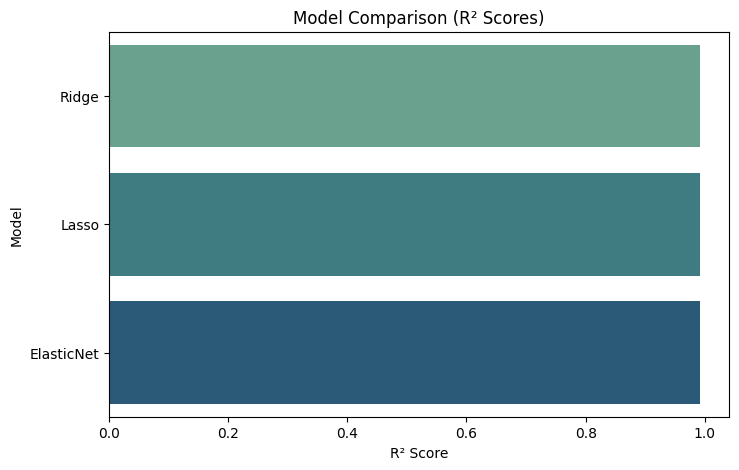

In [21]:
# Visualize R² comparison
model_names = list(results.keys())
r2_scores = [results[name]['r2'] for name in model_names]

plt.figure(figsize=(8, 5))
sns.barplot(x=r2_scores, y=model_names, palette="crest")
plt.title("Model Comparison (R² Scores)")
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.show()
